In [1]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

import sys
sys.path.insert(0, '../../utils')
from DET_utils.DET import DET
from DET_utils.DET_plots import *



mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

# load utils
import sys
sys.path.insert(0, '../utils')
from MagFace_utils.MagFace_funcs_1 import *

# Convert child ids to real ids as in child_balanced.

# For all Ids, get last id name and convert to unique ids
def convert_unique_ids(ids):
    unique_ids_list = []
    for id in ids:
        im_name = id.split("/")[-1][:-4]
        if '.' in im_name:
            un_id = im_name[:-5]
        else:
            un_id = "_".join(im_name.split("_")[:-1])

        unique_ids_list.append(un_id)
    return unique_ids_list

# Get unique ids
def factorize_ids(ids):
    unique_ids = {}
    factors = []
    for id in ids:
        if id not in unique_ids:
            unique_ids[id] = len(unique_ids)  # Assign a unique index for each unique ID
        factors.append(unique_ids[id])  # Append the index corresponding to the ID
    return factors, unique_ids


In [2]:
os.getcwd()

'/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/data_vis'

In [5]:
path_children_feature_vector = '../../data/feature_vectors/feat_children.list'
path_adults_feature_vector = '../../data/feature_vectors/feat_adults_new.list'

In [6]:
# list_of_seeds = [1,2,3,4,5,6,7,8,9,10]

# for i in list_of_seeds:
#     #make subset of the related image_info_csv
#     # store the ids so we can take the subset of features matching these ids
#     # TODO

In [7]:
# load childrens feature vectors and load adults featur vector
with open(path_children_feature_vector, 'r') as f:
    lines = f.readlines()
    # lines make the subset of the features here

img_2_feats = {}
img_2_mag = {}
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
feats = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids_c = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat_c = np.dot(feats, feats.T)
sim_scores_c = sim_mat_c.copy()
plot_sims = sim_scores_c[sim_scores_c < 0.9999].reshape(-1)


In [11]:

with open(path_adults_feature_vector, 'r') as f:
    lines = f.readlines()

img_2_feats = {}
img_2_mag = {}
# Convert to dictionary as adaface - is done in img_2_feats
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
feats_a = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids_a = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat_a = np.dot(feats_a, feats_a.T)
ids_a = convert_unique_ids(ids_a)
factors_a, unique_ids = factorize_ids(ids)


sim_scores_a = sim_mat_a.copy()
plot_sims_a = sim_scores_a[sim_scores_a < 0.999].reshape(-1)


In [12]:

# Mated and non-mated ids
a_df = pd.read_csv('../../data/image_info_csvs/adults_balanced.csv')
c_df = pd.read_csv('../../data/image_info_csvs/child_balanced.csv')

df_c_ofiq = pd.read_csv("../../data/OFIQ_results/children_all_final.csv", sep=";")
df_a_ofiq = pd.read_csv("../../data/OFIQ_results/adults_all_final.csv", sep=";")
df_can_ofiq = pd.read_csv("../../data/OFIQ_results/canonical_children.csv", sep=";")
poor_c_ofiq = df_c_ofiq[df_c_ofiq['UnifiedQualityScore.scalar'] > 29]
poor_a_ofiq = df_a_ofiq[df_a_ofiq['UnifiedQualityScore.scalar'] > 43]
poor_can_ofiq = df_can_ofiq[df_can_ofiq['UnifiedQualityScore.scalar'] > 29]

def extract_identifier(filepath):
    filename = filepath.split('/')[-1]
    parts = filename.split('.')
    if parts[-2].isdigit():
        identifier = '.'.join(parts[-3:-1])
    else:
        identifier = '.'.join(parts[:-1])  # Join everything except the extension
    return identifier

# Apply the function on the DataFrame column
poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)
poor_can_ofiq['Identityname'] = poor_can_ofiq['Filename'].apply(extract_identifier)


/tmp/ipykernel_73190/2986043671.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
/tmp/ipykernel_73190/2986043671.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)


## Subset of entire balanced dist

In [19]:
subset_a_df = a_df[a_df['img_name'].isin(poor_a_ofiq['Identityname'])]
subset_c_df = c_df[c_df['img_name'].isin(poor_c_ofiq['Identityname'])]


In [20]:
# a_mates = subset_a_df.groupby("im_id").agg({'im_id': ['count']})
a_mates = a_df.groupby("im_id").agg({'im_id': ['count']})
a_mated_ids = a_mates[a_mates[('im_id', 'count')] > 1].index
a_nonmated_ids = a_mates[a_mates[('im_id', 'count')] == 1].index


# c_mates = subset_c_df.groupby("im_id").agg({'im_id': ['count']})
c_mates = c_df.groupby("im_id").agg({'im_id': ['count']})
c_mated_ids = c_mates[c_mates[('im_id', 'count')] > 1].index
c_nonmated_ids = c_mates[c_mates[('im_id', 'count')] == 1].index


In [21]:
# children

ids = convert_unique_ids(ids_c)
factors_c, unique_ids = factorize_ids(ids)


## Threshold set based on studying the similarity scores
thold_c = np.percentile(plot_sims, 99)
im_ids_c = np.array(factors_c)

mated_df = c_mated_ids
non_mated_df = c_nonmated_ids
sim_scores = sim_scores_c
im_ids = im_ids_c
ids = ids

fnir_c = compute_fnir(c_mated_ids, sim_scores, im_ids_c, ids, thold=thold_c)
fpir_c = compute_fpir(c_nonmated_ids, sim_scores, im_ids_c, ids, thold=thold_c)


# adults
thold_a = np.percentile(plot_sims_a, 99)
im_ids_a = np.array(factors_a)

mated_df = a_mated_ids
non_mated_df = a_nonmated_ids
sim_scores = sim_scores_a
im_ids = im_ids_a
ids = ids_a

fnir_a = compute_fnir(mated_df, sim_scores_a, im_ids, ids, thold=thold_a)
fpir_a = compute_fpir(non_mated_df, sim_scores_a, im_ids, ids, thold=thold_a)


In [22]:
mated_scores1 = fnir_c[1]
nonmated_scores1 = fpir_c[1]
scores_type1 = "similarity"

mated_scores2 = fnir_a[1]
nonmated_scores2 = fpir_a[1]
scores_type2 = "similarity"

In [23]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df.round(round_digits).style.hide_index())

stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df.round(round_digits).style.hide_index())

/tmp/ipykernel_73190/835943763.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(stats_system1_df.round(round_digits).style.hide_index())


Statistic,Mated,Non-mated
Observations,4050.000000,4028795.000000
Minimum,0.078510,-0.377520
Maximum,0.989440,0.984690
Mean,0.623880,0.142260
St. Dev.,0.152450,0.136350
Skewness,-0.358280,0.249530
Ex. Kurtosis,-0.195040,-0.075410


/tmp/ipykernel_73190/835943763.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(stats_system2_df.round(round_digits).style.hide_index())


Statistic,Mated,Non-mated
Observations,722.000000,8551688.000000
Minimum,-0.004130,-0.328600
Maximum,0.964100,0.803650
Mean,0.435790,0.204640
St. Dev.,0.153310,0.119020
Skewness,-0.007400,0.024610
Ex. Kurtosis,0.078870,-0.024610


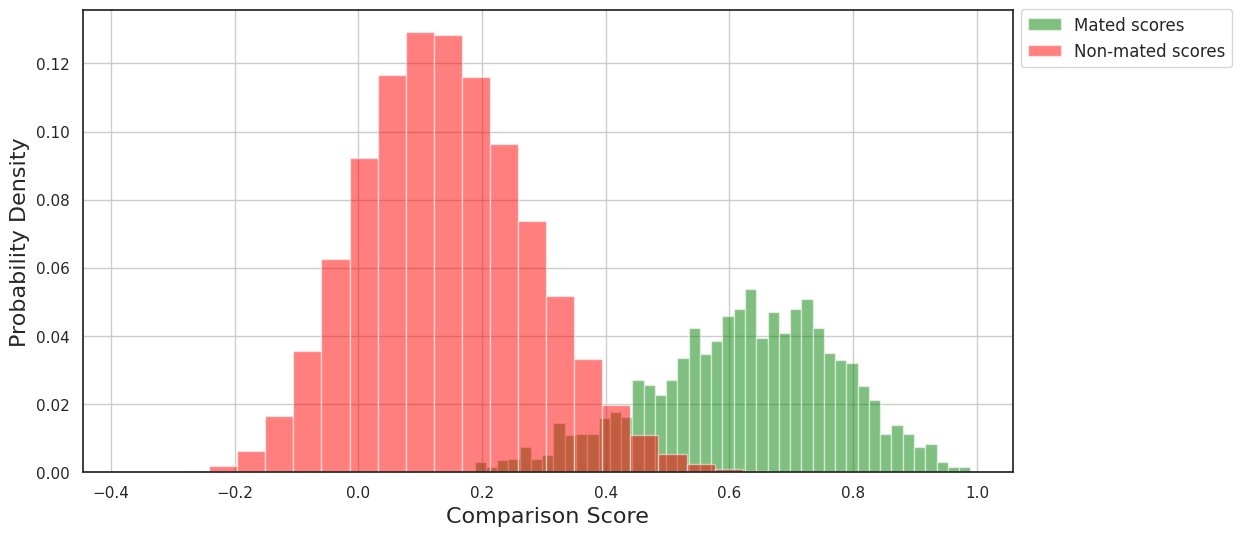

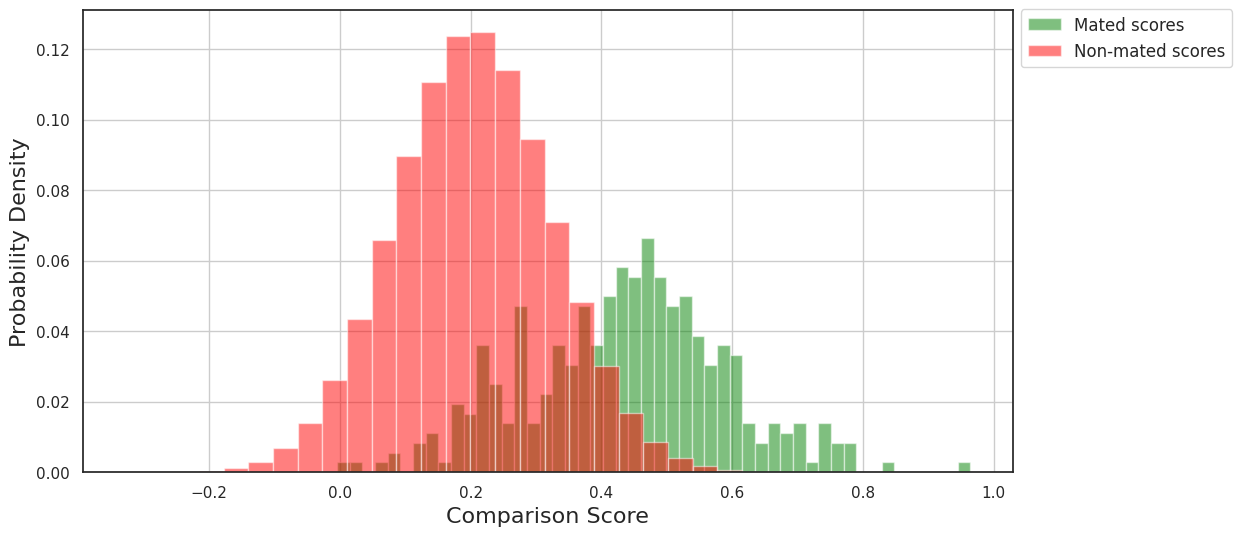

In [24]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)

In [ ]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [ ]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores2)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores2)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [ ]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

In [ ]:
threshold1 = 0.36
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

In [ ]:
threshold2 = 0.32
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

In [ ]:
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count"))

In [ ]:
det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()